# Cohesive Topics for Books: Cluster books by description
This project will use TF-IDF, Word2Vec, and NMF to cluster books from Amazon into topics based on their book descriptions.
Data source: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews/

In [1]:
import numpy as np
import pandas as pd
from difflib import SequenceMatcher
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

import subprocess

from nltk.corpus import wordnet

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

from sklearn.decomposition import NMF
import re
import gensim
from itertools import combinations


In [2]:
# Load data
books_df = pd.read_csv(r"C:\Users\mmull\OneDrive\Documents\MSDS\ML Unsupervised Project\books_data.csv\books_data.csv")

In [3]:
books_df.head()

Title  \
0                     Its Only Art If Its Well Hung!   
1                           Dr. Seuss: American Icon   
2              Wonderful Worship in Smaller Churches   
3                      Whispers of the Wicked Saints   
4  Nation Dance: Religion, Identity and Cultural ...   

                                         description              authors  \
0                                                NaN     ['Julie Strain']   
1  Philip Nel takes a fascinating look into the k...       ['Philip Nel']   
2  This resource includes twelve principles in un...     ['David R. Ray']   
3  Julia Thomas finds her life spinning out of co...  ['Veronica Haddon']   
4                                                NaN      ['Edward Long']   

                                               image  \
0  http://books.google.com/books/content?id=DykPA...   
1  http://books.google.com/books/content?id=IjvHQ...   
2  http://books.google.com/books/content?id=2tsDA...   
3  http://books.google.com/books/content?id=aRSIg...   
4                                                NaN   

                                         previewLink  publisher publishedDate  \
0  http://books.google.nl/books?id=DykPAAAACAAJ&d...        NaN          1996   
1  http://books.google.nl/books?id=IjvHQsCn_pgC&p...  A&C Black    2005-01-01   
2  http://books.google.nl/books?id=2tsDAAAACAAJ&d...        NaN          2000   
3  http://books.google.nl/books?id=aRSIgJlq6JwC&d...  iUniverse       2005-02   
4  http://books.google.nl/books?id=399SPgAACAAJ&d...        NaN    2003-03-01   

                                            infoLink  \
0  http://books.google.nl/books?id=DykPAAAACAAJ&d...   
1  http://books.google.nl/books?id=IjvHQsCn_pgC&d...   
2  http://books.google.nl/books?id=2tsDAAAACAAJ&d...   
3  http://books.google.nl/books?id=aRSIgJlq6JwC&d...   
4  http://books.google.nl/books?id=399SPgAACAAJ&d...   

                      categories  ratingsCount  
0    ['Comics & Graphic Novels']           NaN  
1  ['Biography & Autobiography']           NaN  
2                   ['Religion']           NaN  
3                    ['Fiction']           NaN  
4                            NaN           NaN

## Data Cleaning
- Remove columns
- Drop NAs
- Drop descriptions below threshold
- Delete extra editions of books

In [4]:
# Drop columns
books_df.drop(['image', 'previewLink', 'infoLink', 'ratingsCount', 'publishedDate', 'publisher'], axis = 1, inplace = True)

In [52]:
# Remove square brackets and quotation marks
books_df['categories'] = books_df['categories'].str.strip('[]\'')
books_df['authors'] = books_df['authors'].str.strip('[]\'')

# Remove rows with nulls
books_df.dropna(inplace = True)
books_df.drop(books_df[books_df['authors'] == 'nan'].index, inplace=True)

# Delete descriptions with length below threshold (median length)

desc_length = books_df['description'].str.len()
removed = desc_length[desc_length < 553]
books_df.drop(removed.index, axis = 0, inplace = True)

In [6]:
# Check for duplicates
books_df[books_df['authors'] == 'Herman Melville']

Title  \
18444                               The Lightning-Rod Man   
24377                                           Moby Dick   
39759   Moby Dick, or The Whale (The 100 Greatest Book...   
65102   Moby-Dick: or, The Whale (Penguin Classics Del...   
79776                          Moby Dick;: Or, The whale,   
110202                             Moby Dick Or the Whale   
111999  Omoo: A narrative of adventures in the South seas   
116082                             Moby-Dick or The Whale   
117282                                      Israel Potter   
133567               Billy Budd, Sailor and Other Stories   
140100  Omoo: A narrative of adventures in the South Seas   
150443                         Pierre or, the Ambiguities   
156306  Israel Potter,: His fifty years of exile (The ...   
158442  Moby Dick or The White Whale (World's Greatest...   
169403                       Moby Dick or the White Whale   
179684      Moby Dick or the Whale (The World's Classics)   
204326              Billy Budd, Sailor, and Other Stories   
210776  The Complete Works of Herman Melville (The Com...   

                                              description          authors  \
18444   When an unnamed narrator opens his door to a l...  Herman Melville   
24377   Moby Dick is a novel by American author Herman...  Herman Melville   
39759   Moby Dick is a novel by American writer Herman...  Herman Melville   
65102   Herman Melville’s masterpiece, one of the grea...  Herman Melville   
79776   Moby Dick is a novel by American writer Herman...  Herman Melville   
110202  Moby-Dick is one of the great epics in all of ...  Herman Melville   
111999  Melville’s continuing adventures in the South ...  Herman Melville   
116082  Moby-Dick is one of the great epics in all of ...  Herman Melville   
117282  "Israel Potter: His Fifty Years of Exile" by H...  Herman Melville   
133567  If Melville had never written Moby Dick, his p...  Herman Melville   
140100  Melville’s continuing adventures in the South ...  Herman Melville   
150443  THERE are some strange summer mornings in the ...  Herman Melville   
156306  Based on the life of an actual soldier who cla...  Herman Melville   
158442  Moby Dick is a novel by American writer Herman...  Herman Melville   
169403  Moby Dick is a novel by American writer Herman...  Herman Melville   
179684  Moby Dick is a novel by American author Herman...  Herman Melville   
204326  If Melville had never written Moby Dick, his p...  Herman Melville   
210776  This carefully crafted ebook: "The Complete Wo...  Herman Melville   

                 categories  
18444               Fiction  
24377   Young Adult Fiction  
39759               Fiction  
65102               Fiction  
79776               Fiction  
110202              Fiction  
111999              Fiction  
116082              Fiction  
117282              Fiction  
133567              Fiction  
140100              Fiction  
150443              Fiction  
156306     American fiction  
158442              Fiction  
169403              Fiction  
179684  Young Adult Fiction  
204326              Fiction  
210776              Fiction

In [7]:
# Find and delete duplicates of books (same book with different editions)

def similar(str1, str2):
    return SequenceMatcher(None, str1, str2).ratio()

def find_duplicate_books(df, authors):
    for author in authors:
        for title1 in df[df['authors'] == author]['Title']:
            for title2 in df[df['authors'] == author]['Title']:
                similarity = similar(title1, title2)
                if similarity > 0.6 and similarity < 1:
                    df.drop(df.loc[df['Title'] == title2].index, inplace=True)

In [8]:
authors = books_df['authors'].value_counts()
target_authors = (authors > 1).index.to_list()
find_duplicate_books(books_df, target_authors)

## EDA
Histograms for authors and categories. Descriptive statistics for authors, categories, and descriptions.

Text(0.5, 1.0, 'Top 20 Authors')

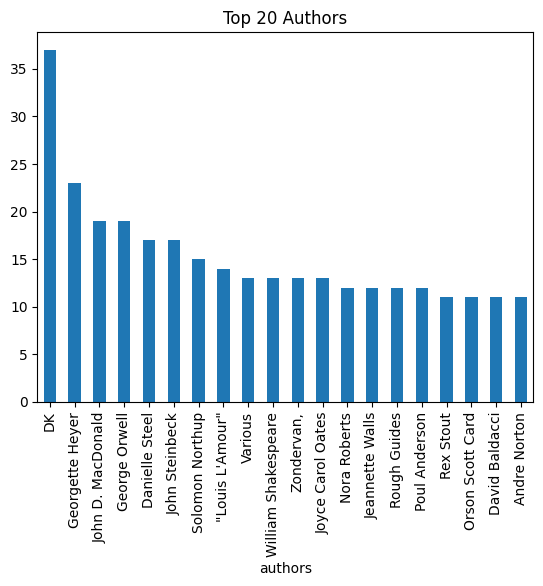

In [62]:
author_counts = books_df['authors'].value_counts()
top = author_counts[:20]
fig, ax = plt.subplots()
top.plot(ax = ax, kind = 'bar')
plt.title('Top 20 Authors')

Text(0.5, 1.0, 'Top 20 Categories (by Book Count)')

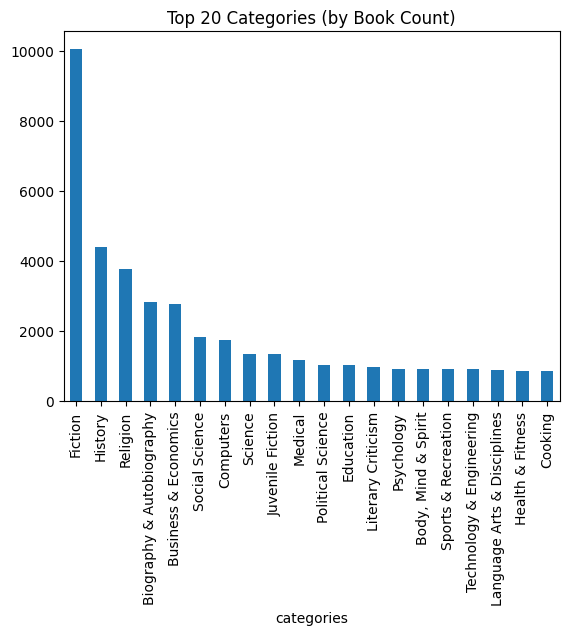

In [30]:
category_counts_book = books_df['categories'].value_counts()
top_by_book = category_counts_book[:20]
fig, ax = plt.subplots()
top_by_book.plot(ax = ax, kind = 'bar')
plt.title('Top 20 Categories (by Book Count)')

In [75]:
# Mean, median, min, max
for feat in [('authors', author_counts), ('categories', category_counts_book), ('descriptions', books_df['description'].str.len())]:
    print(feat[0])
    print('Mean:', np.mean(feat[1]))
    print('Median:', np.median(feat[1]))
    print('Min:', np.min(feat[1]))
    print('Max:', np.max(feat[1]))

authors
Mean: 1.162163689803301
Median: 1.0
Min: 1
Max: 37
categories
Mean: 30.099571734475376
Median: 1.0
Min: 1
Max: 10048
descriptions
Mean: 939.1645104810077
Median: 834.0
Min: 553
Max: 14086


## Pre-processing Text

In [10]:
# Text preprocessing
# Clean text by removing stop words and punctuation
def clean_text(txt):
    
    # Remove punctuation
    txt  = "".join([char if char not in string.punctuation else ' ' for char in txt ])
    
    # Convert to lowercase
    txt = txt.lower()
    
    # Split into words
    words = word_tokenize(txt)
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    for w in range(len(words)): 
        words[w] = lemmatizer.lemmatize(words[w])
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # Removing remaining nonalphabetic words
    words = [word for word in words if word.isalpha()]
    
    # Rejoin the text
    cleaned_text = ' '.join(words)
    
    return cleaned_text

In [11]:
# Clean the description text
books_df['description'] = books_df['description'].apply(lambda txt: clean_text(txt))
books_df.head()

Title  \
1                            Dr. Seuss: American Icon   
3                       Whispers of the Wicked Saints   
5   The Church of Christ: A Biblical Ecclesiology ...   
11                        Dramatica for Screenwriters   
12   Mensa Number Puzzles (Mensa Word Games for Kids)   

                                          description                authors  \
1   philip nel take fascinating look key aspect se...             Philip Nel   
3   julia thomas find life spinning control death ...        Veronica Haddon   
5   church christ biblical ecclesiology today resp...       Everett Ferguson   
11  dramatica screenwriter armando saldana mora mu...   Armando Salda A-Mora   
12  acclaimed teacher puzzler evelyn b christensen...  Evelyn B. Christensen   

                   categories  
1   Biography & Autobiography  
3                     Fiction  
5                    Religion  
11                  Reference  
12        Juvenile Nonfiction

In [44]:
# Word count analysis
word_count = books_df['description'].str.split(expand = True).stack().value_counts()
most_frequent = word_count[word_count > 1000]
least_frequent = word_count[word_count == 1]
print('Unique words: ', word_count.shape[0])
print('Most frequent words: ', most_frequent.shape[0])
print('Words with single occurrence: ', least_frequent.shape[0])


Unique words:  147802
Most frequent words:  1183
Words with single occurrence:  67679


book           50028
new            34345
life           30830
ha             30281
one            27513
wa             25930
world          23285
time           21597
year           18452
work           18181
first          17970
story          17969
author         16574
history        14708
also           14220
way            13203
well           12804
american       12543
reader         12201
many           12096
woman          12048
make           11853
guide          11501
edition        11275
u              11200
people         10938
family         10932
love           10833
help           10820
student        10601
war            10541
find           10503
study          10377
child          10064
two             9903
de              9707
best            9450
including       9417
chapter         8807
take            8766
need            8717
day             8679
offer           8631
like            8538
information     8517
century         8443
text            8033
provides     

## Modeling
Random subsets of 25% of the dataset will be used for analysis. TF-IDF and Word2Vec will be conducted before training the NMF model

In [13]:
# Subset
subset = books_df.sample(frac = 0.25, random_state = 0)


In [14]:
# TF-IDF 

tfidf = TfidfVectorizer(stop_words = 'english', max_df = 0.95, min_df = 5)
# IDF values and word coordinates (document index, word index) in matrix
subset_matrix = tfidf.fit_transform(subset['description']).todense()
# Array of words included in the matrix
vocabulary = np.array(tfidf.get_feature_names_out())

In [20]:
# Word2Vec

class TokenGenerator:
    def __init__(self, documents):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__(self):
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                tokens.append( tok )
            yield tokens

In [21]:
docgen = TokenGenerator(subset['description'])
w2v_model = gensim.models.Word2Vec(docgen, min_count = 2)
print("Model has %d terms" % len(w2v_model.wv.key_to_index))

Model has 39029 terms


### Use subset to choose n_components
Values of n_components will range from 20-140. The evaluation metric is mean coherence across topics produced.

In [15]:
# Check number of categories in full dataset to set reasonable parameter choices
count = books_df['categories'].value_counts()
print('Unique:', len(books_df['categories'].unique()))
print('Categories with 5+ books:', len(count[count > 4]))

Unique: 1868
Categories with 5+ books: 122


In [22]:
# Functions to calculate coherence and identify top terms within topics

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

def calculate_coherence(model, term_rankings):
    overall_coherence = 0.0
    topic_scores = []
    for topic_index in range(len(term_rankings)):
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            if pair[0] not in w2v_model.wv or pair[1] not in w2v_model.wv:
                continue
            pair_scores.append(w2v_model.wv.similarity(pair[0], pair[1]))
        topic_score = np.mean(pair_scores)
        overall_coherence += topic_score
        topic_scores.append(topic_score)
    return overall_coherence/len(term_rankings), topic_scores



In [25]:
# Create models with different values for n_components

k = range(20, 151, 20)
topic_models = []
for i in k:
    nmf = NMF(n_components = i, init = 'nndsvd', max_iter = 400, random_state = 0)
    W = nmf.fit_transform(np.asarray(subset_matrix))
    H = nmf.components_
    topic_models.append((i, W, H))


C:\Users\mmull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


In [26]:
k_values = []
coherences = []
for (k, W, H) in topic_models:
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append(get_descriptor(vocabulary, H, topic_index, 10))
    k_values.append(k)
    mean_coherence, topic_scores = calculate_coherence(w2v_model, term_rankings)
    coherences.append(mean_coherence)
    print(k, coherences[-1])

20 0.6210043378174305
40 0.6588542871177197
60 0.6554128115375837
80 0.6537355493754149
100 0.64743527084589
120 0.6458271066347758
140 0.6480557288442339


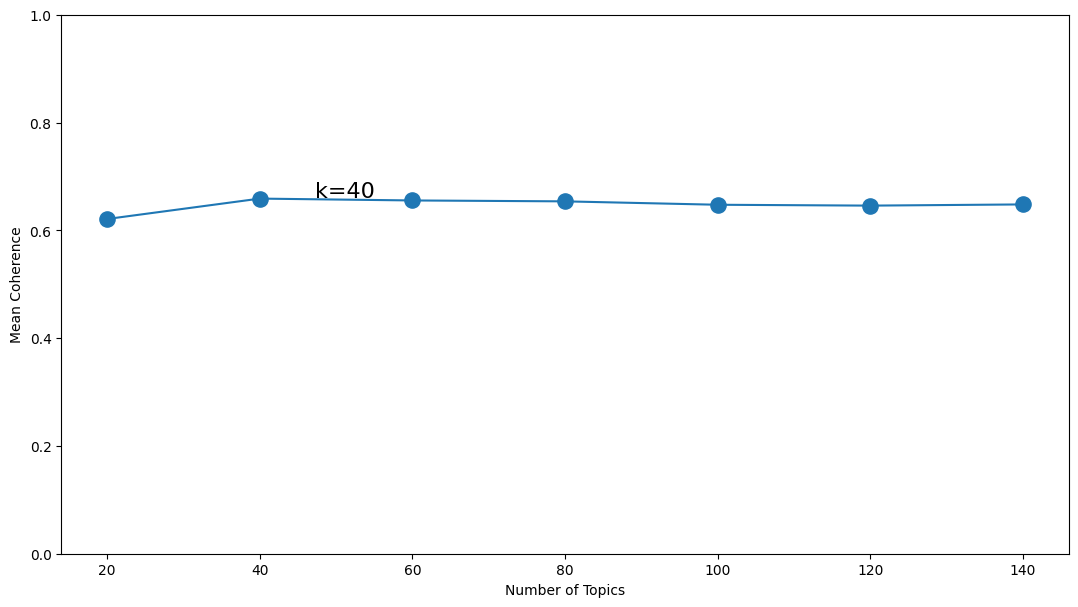

In [27]:
fig = plt.figure(figsize=(13,7))
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.title('Mean Coherences for k Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Mean Coherence')
plt.ylim(0, 1)
# add the points
plt.scatter(k_values, coherences, s=120)
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate('k=%d' % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords='offset points', fontsize=16)
plt.show()

## Tuning other hyperparameters

In [18]:
# Test different hyperparameters with subset
models = [NMF(n_components = 40, solver = 'mu', init = 'nndsvdar', max_iter = 400, random_state = 0), 
          NMF(n_components = 40, solver = 'mu', init = 'nndsvdar', beta_loss = 'kullback-leibler', max_iter = 400, random_state = 0)]
test_models = []
for i in models:
    W = i.fit_transform(np.asarray(subset_matrix))
    H = i.components_
    test_models.append((i, W, H))


ValueError: When beta_loss <= 0 and X contains zeros, the solver may diverge. Please add small values to X, or use a positive beta_loss.

In [24]:
# Coherence for each different model
coherences = []
for (i, W, H) in test_models:
    term_rankings = []
    for topic_index in range(40):
        term_rankings.append(get_descriptor(vocabulary, H, topic_index, 10))
    mean_coherence, topic_scores = calculate_coherence(w2v_model, term_rankings)
    coherences.append(mean_coherence)
    print(coherences[-1])

0.6380419507622719
0.6065995387732983


In [28]:
# Evaluate coherence of other subsets using optimal model
optimal = NMF(n_components = i, init = 'nndsvd', max_iter = 400, random_state = 0)
subsets = []
for i in range(5):
    subsets.append(books_df.sample(frac = 0.25, random_state = i+1))

for subset in subsets:
    matrix = tfidf.fit_transform(subset['description']).todense()
    vocabulary = np.array(tfidf.get_feature_names_out())
    docgen = TokenGenerator(subset['description'])
    w2v_model = gensim.models.Word2Vec(docgen, min_count = 2)
    W = optimal.fit_transform(np.asarray(matrix))
    H = optimal.components_
    coherences = []
    term_rankings = []
    for topic_index in range(40):
        term_rankings.append(get_descriptor(vocabulary, H, topic_index, 10))
    mean_coherence, topic_scores = calculate_coherence(w2v_model, term_rankings)
    coherences.append(mean_coherence)
    print(coherences[-1])

0.6545277275145054
0.6405277155339718
0.6569411434233189
0.6506180994212627
0.6649139992892742


In [29]:
# Print keywords for each topic for one of the subsets
for topic_index in range(40):
    descriptor = get_descriptor(vocabulary, H, topic_index, 10)
    str_descriptor = ", ".join(descriptor)
    print("Topic %02d: %s" % (topic_index+1, str_descriptor))
    

Topic 01: world, international, ii, modern, peace, place, global, today, country, humanity
Topic 02: problem, solution, solving, mathematical, mathematics, engineering, solve, application, number, equation
Topic 03: een, en, van, het, zijn, te, op, voor, met, haar
Topic 04: history, historian, historical, event, account, period, present, narrative, fascinating, past
Topic 05: god, faith, christ, truth, divine, glory, grace, lord, eternal, believer
Topic 06: la, que, en, el, una, los, su, se, para, del
Topic 07: management, manager, organization, risk, leadership, software, resource, team, strategy, company
Topic 08: child, adult, childhood, young, development, birth, age, abuse, infant, special
Topic 09: recipe, cookbook, cooking, cook, meal, dish, kitchen, delicious, ingredient, bread
Topic 10: war, civil, army, battle, soldier, military, german, ii, conflict, men
Topic 11: help, understand, practical, skill, advice, need, learn, offer, idea, situation
Topic 12: career, job, resume, p